In [303]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor
import sklearn.model_selection as ms
from sklearn import ensemble
from sklearn import metrics
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go

In [304]:
import warnings
warnings.filterwarnings('ignore')

In [305]:
df = pd.read_csv('model_data.csv', index_col=0,low_memory=False)

In [306]:
df = df.fillna(0)
df = df.sort_index(axis=1)
# sort column names alphabetically

In [307]:
df.head()

,AllBathAbv,AllBathBsmt,BsmtCond,BsmtUnfSF,CentralAir,ExterQual,FireplaceQu,Foundation,GarageCars,GarageQual,GoodLivArea,HasPool,HeatingQC,KitchenQual,MSSubClass,Neighborhood,PavedDrive,PorchArea,SalePrice,YearBuilt
PID,,,,,,,,,,,,,,,,,,,,
526301100,1.0,1.0,Gd,441.0,Y,TA,Gd,CBlock,2.0,TA,2295.0,0,Fa,TA,1Fl,NAmes,P,272,215000,1960
526302030,2.0,1.0,TA,171.0,Y,TA,None,CBlock,2.0,TA,2300.0,0,Gd,TA,1Fl,NAmes,Y,280,149900,1954
526302040,1.0,1.0,TA,235.0,Y,TA,TA,CBlock,1.0,TA,1797.0,0,TA,Gd,1Fl,NAmes,Y,280,157500,1956
526302110,1.0,0.0,Fa,318.0,Y,TA,None,CBlock,1.0,TA,1446.0,0,TA,TA,1Fl,NAmes,Y,0,124500,1956
526302120,1.5,0.0,TA,490.0,Y,TA,TA,CBlock,3.0,TA,2924.0,0,Fa,TA,1Fl,NAmes,Y,0,169000,1957


In [308]:
dummies = pd.get_dummies(df[['AllBathBsmt','AllBathAbv','BsmtCond','CentralAir','ExterQual','FireplaceQu','Foundation',
                          'GarageCars','GarageQual','HeatingQC', 'KitchenQual','MSSubClass','Neighborhood','PavedDrive']],drop_first=True)

In [309]:
df_constants = df.drop(['AllBathBsmt','AllBathAbv','BsmtCond','CentralAir','ExterQual','FireplaceQu','Foundation',
           'GarageCars','GarageQual','HeatingQC', 'KitchenQual','MSSubClass','Neighborhood','PavedDrive'],axis=1)

In [310]:
X = pd.concat([dummies,df_constants],axis=1)
y = X['SalePrice']
X = X.drop(['SalePrice'],axis=1)

In [311]:
if len(X.index) == len(y.index):
    print('There is an equal number of rows')
else : print('Unequal rows')

There is an equal number of rows


In [312]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)
mlr = LinearRegression()

In [313]:
mlr.fit(x_train,y_train)
y_predict =  mlr.predict(x_test)
mlr_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_predict})
mlr_diff.head()

,Actual value,Predicted value
PID,,
535457010,160000,125439.244936
527401130,133000,130699.446467
907126030,155000,159889.002607
528315080,300000,298352.639583
535457040,141000,142521.520271


In [314]:
meanAbErr = metrics.mean_absolute_error(y_test, y_predict)
meanSqErr = metrics.mean_squared_error(y_test, y_predict)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_predict))
print('R squared: {:.2f}'.format(mlr.score(X,y) * 100))
print('Mean Absolute Error:', meanAbErr)
print('Mean Square Error:', meanSqErr)
print('Root Mean Square Error:', rootMeanSqErr)

R squared: 88.82
Mean Absolute Error: 17564.98321697658
Mean Square Error: 763251297.2338201
Root Mean Square Error: 27627.00304473542


<h2>Time to do CatBoost</h2>

Label Encoding

In [315]:
df.Neighborhood.value_counts()

NAmes      410
CollgCr    236
OldTown    213
Edwards    165
Gilbert    143
Somerst    143
Sawyer     139
NWAmes     123
NridgHt    121
SawyerW    113
Mitchel    104
BrkSide    103
Crawfor     92
IDOTRR      76
NoRidge     67
Timber      54
StoneBr     43
SWISU       42
ClearCr     40
MeadowV     34
BrDale      29
Veenker     23
Blmngtn     23
NPkVill     22
Blueste     10
Greens       8
GrnHill      2
Landmrk      1
Name: Neighborhood, dtype: int64

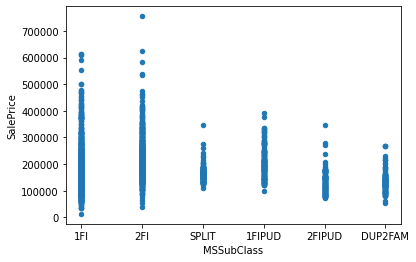

In [316]:
df.plot.scatter(x='MSSubClass',y='SalePrice');

In [317]:
df['CentralAir'] = df['CentralAir'].map(lambda x: 0 if x == 'N' else 1)

df['Foundation'] = df['Foundation'].replace({'Wood':1,'Stone':2,'Slab':3,'BrkTil':4,'CBlock':5,'PConc':6})

df['KitchenQual'] = df['KitchenQual'].replace({'Po': 'Fa'})
df['KitchenQual'] = df['KitchenQual'].replace({'Fa':1,'TA':2,'Gd':3,'Ex':4})

df['ExterQual'] = df['ExterQual'].replace({'Fa':1,'TA':2,'Gd':3,'Ex':4})

df['FireplaceQu'] = df['FireplaceQu'].replace({'Po': 'Fa'})
df['FireplaceQu'] = df['FireplaceQu'].replace({'None':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})

df['GarageQual'] = df['GarageQual'].replace({'Po': 'Fa','Ex':'Gd'})
df['GarageQual'] = df['GarageQual'].replace({'None':0,'Fa':1,'TA':2,'Gd':3})

df['BsmtCond'] = df['BsmtCond'].replace({'Po': 'Fa','Ex':'Gd'})
df['BsmtCond'] = df['BsmtCond'].replace({'None':0,'Fa':1,'TA':2,'Gd':3})

df['PavedDrive'] = df['PavedDrive'].replace({'P': 'Y'})
df['PavedDrive'] = df['PavedDrive'].map(lambda x: 0 if x == 'N' else 1)

df['HeatingQC'] = df['HeatingQC'].replace({'Fa':1,'TA':2,'Gd':3,'Ex':4})

df['MSSubClass'] = df['MSSubClass'].replace({'DUP2FAM':1,'2FlPUD':2,'SPLIT':3,'1FlPUD':4,'1Fl': 5,'2Fl':6})
#HasPool already exists

In [318]:
df.Foundation.value_counts()

5    1139
6    1105
4     278
3      42
2      10
1       5
Name: Foundation, dtype: int64

In [324]:
y = df['SalePrice']
df = df.drop(['SalePrice','Neighborhood'],axis=1)
X = df

KeyError: 'SalePrice'

In [330]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 1)

In [334]:
model = CatBoostRegressor(metric_period=100)

In [336]:
model.fit(x_train, y_train)
print("The training r2: %.5f" % (model.score(x_train, y_train)))
print("The test     r2: %.5f" % (model.score(x_test, y_test)))

Learning rate set to 0.046348
0:	learn: 72541.2121126	total: 1.26ms	remaining: 1.26s
100:	learn: 22943.0531262	total: 103ms	remaining: 919ms
200:	learn: 20039.4181381	total: 189ms	remaining: 753ms
300:	learn: 18198.5179595	total: 271ms	remaining: 629ms
400:	learn: 16734.1207859	total: 354ms	remaining: 529ms
500:	learn: 15524.2632512	total: 439ms	remaining: 437ms
600:	learn: 14551.5182343	total: 517ms	remaining: 343ms
700:	learn: 13660.6761125	total: 598ms	remaining: 255ms
800:	learn: 12885.9516962	total: 676ms	remaining: 168ms
900:	learn: 12270.8127980	total: 754ms	remaining: 82.9ms
999:	learn: 11707.0037080	total: 827ms	remaining: 0us
The training r2: 0.97559
The test     r2: 0.90309
